<a href="https://colab.research.google.com/github/clayedw/RET-2024/blob/main/Redshift_binning_with_autocorrelations_7_8_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#The code below comes from LSSTDESC/CCLX and uses that of:
#  Niko Sarcevic
#  nikolina.sarcevic@gmail.com
#  github.com/nikosarcevic
#and
#  Andrina Nicola
#  anicola[at]astro[dot]princeton[dot]edu
#  github.com/Andrina Nicola
#and
#  Elisa Chisari
#  n.e.chisari@uu.nl
#  #  github.com/elisachisari

!pip install -q condacolab

import condacolab

condacolab.install()

!conda install --no-pin pyccl

import pyccl as ccl

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



Redshift Distribution: The redshift distribution is defined and plotted.


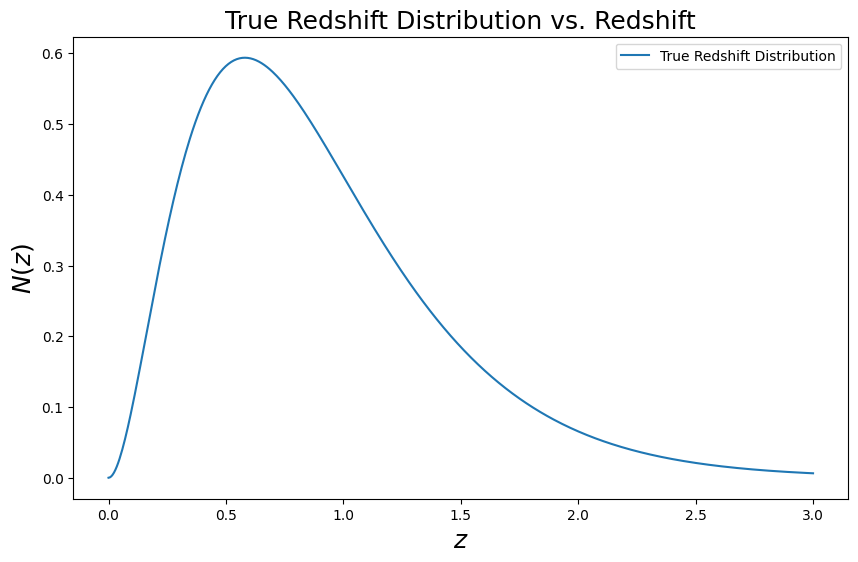

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from scipy import integrate
from scipy.special import erf

class SRDRedshiftDistributions:
    def __init__(self, redshift_range):
        self.redshift_range = redshift_range

    def smail_type_distribution(self, pivot_redshift, alpha, beta):
        redshift_distribution = [(z / pivot_redshift) ** beta * np.exp(-(z / pivot_redshift) ** alpha) for z in self.redshift_range]
        return np.array(redshift_distribution)

# Define cosmological parameters
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Define redshift range and distribution parameters
redshift_range = np.linspace(0.0, 3.0, 512)
beta = 2.0
alpha = 0.94
pivot_redshift = 0.26

# Instantiate SRDRedshiftDistributions and get redshift distribution
srd = SRDRedshiftDistributions(redshift_range)
redshift_distribution = srd.smail_type_distribution(pivot_redshift, alpha, beta)

# Plot the true redshift distribution
plt.figure(figsize=(10, 6))
plt.plot(redshift_range, redshift_distribution, label='True Redshift Distribution')
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('True Redshift Distribution vs. Redshift', fontsize=18)
plt.legend()
plt.show()


Binning Class: The Binning class is defined to handle binning the redshift distribution into tomographic bins with equal number density.

Compute Equal Number Density Bins: The compute_equal_number_bounds method determines the bin edges that result in equal number densities.

Lens Bins: The lens_bins method computes the redshift distributions for each bin, normalizing them if specified.

Plotting: The redshift distributions for each bin are plotted to visualize the results.

Bin edges: [0.0, 0.5202868646340291, 0.7736946956027205, 1.0496654720590626, 1.4404486933924936, 3.0]


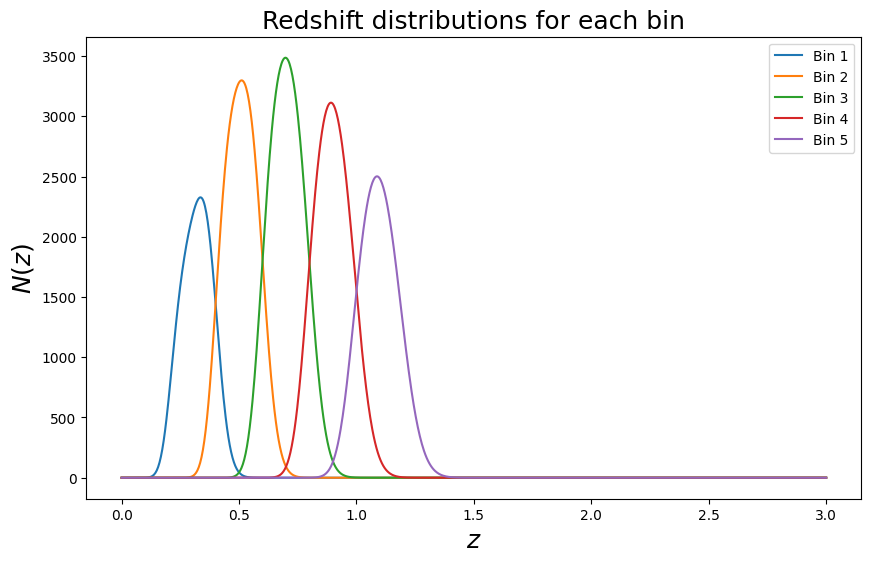

In [15]:
class Binning:
    def __init__(self, redshift_range, redshift_distribution, forecast_year):
        supported_forecast_years = {"1", "10"}
        if forecast_year in supported_forecast_years:
            self.forecast_year = forecast_year
        else:
            raise ValueError(f"forecast_year must be one of {supported_forecast_years}.")

        self.redshift_range = redshift_range
        self.redshift_distribution = redshift_distribution

        with open("lsst_desc_parameters.yaml", "r") as f:
            self.lsst_parameters = yaml.load(f, Loader=yaml.FullLoader)

        self.lens_params = self.lsst_parameters["lens_sample"][self.forecast_year]
        self.source_params = self.lsst_parameters["source_sample"][self.forecast_year]

    def true_redshift_distribution(self, upper_edge, lower_edge, variance, bias):
        scatter = variance * (1 + self.redshift_range)
        lower_limit = (upper_edge - self.redshift_range + bias) / np.sqrt(2) / scatter
        upper_limit = (lower_edge - self.redshift_range + bias) / np.sqrt(2) / scatter
        true_redshift_distribution = 0.5 * np.array(self.redshift_distribution) * (erf(upper_limit) - erf(lower_limit))
        return true_redshift_distribution

    def compute_equal_number_bounds(self, redshift_range, redshift_distribution, n_bins):
        cumulative_distribution = integrate.cumulative_trapezoid(redshift_distribution, redshift_range, initial=0)
        total_galaxies = cumulative_distribution[-1]
        bin_edges = []
        for i in range(1, n_bins):
            fraction = i / n_bins * total_galaxies
            bin_edge = np.interp(fraction, cumulative_distribution, redshift_range)
            bin_edges.append(bin_edge)
        return [redshift_range[0]] + bin_edges + [redshift_range[-1]]

    def lens_bins(self, normalised=True, save_file=True, file_format='npy'):
        bins = np.arange(self.lens_params["bin_start"],
                         self.lens_params["bin_stop"] + self.lens_params["bin_spacing"],
                         self.lens_params["bin_spacing"])

        lens_z_bias_list = np.repeat(self.lens_params["z_bias"], self.lens_params["n_tomo_bins"])
        lens_z_variance_list = np.repeat(self.lens_params["sigma_z"], self.lens_params["n_tomo_bins"])

        lens_redshift_distribution_dict = {}
        for index, (x1, x2) in enumerate(zip(bins[:-1], bins[1:])):
            z_bias = lens_z_bias_list[index]
            z_variance = lens_z_variance_list[index]
            lens_redshift_distribution_dict[index] = self.true_redshift_distribution(x1, x2, z_variance, z_bias)

        if normalised:
            norm_factor = []
            for i, key in enumerate(list(sorted(lens_redshift_distribution_dict.keys()))):

                norm_factor

        combined_data = {'redshift_range': self.redshift_range, 'bins': lens_redshift_distribution_dict}

        if save_file:
            self.save_to_file(combined_data, "lens", file_format)

        return lens_redshift_distribution_dict

    def get_bin_centers(self, decimal_places=2, save_file=True):
        bin_centers = {"sources": [], "lenses": []}
        lens_bins = self.lens_bins(normalised=True, save_file=False)
        for index in range(self.lens_params["n_tomo_bins"]):
            bin_center = self.find_bin_center(lens_bins[index], self.redshift_range, decimal_places)
            bin_centers["lenses"].append(bin_center)
        if save_file:
            np.save(f'./srd_bin_centers_y_{self.forecast_year}.npy', bin_centers)
        return bin_centers

    def find_bin_center(self, bin_distribution, redshift_range, decimal_places=2):
        max_index = np.argmax(bin_distribution)
        return round(redshift_range[max_index], decimal_places)

    def save_to_file(self, data, name, file_format="npy"):
        if file_format == "npy":
            np.save(f"./srd_{name}_bins_year_{self.forecast_year}.npy", data)
        elif file_format == "csv":
            dndz_df = pandas.DataFrame(data)
            dndz_df.to_csv(f"./srd_{name}_bins_year_{self.forecast_year}.csv", index=False)

# Instantiate and use the Binning class
forecast_year = "1"  # For year 1
binning = Binning(z, dNdz, forecast_year)

# Compute equal number density bins
n_bins = 5  # Number of bins for year 1
bin_edges = binning.compute_equal_number_bounds(z, dNdz, n_bins)
print("Bin edges:", bin_edges)

# Compute the redshift distributions for each bin
lens_bins = binning.lens_bins(normalised=True, save_file=False)
#print("Lens bins:", lens_bins)

# Plot the redshift distributions for each bin
plt.figure(figsize=(10, 6))
for i in range(n_bins):
    plt.plot(z, lens_bins[i], label=f'Bin {i+1}')
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('Redshift distributions for each bin', fontsize=18)
plt.legend()
plt.show()


Creating the NumberCountsTracer objects for each bin.

Plotting the Angular Power Spectra for each bin.

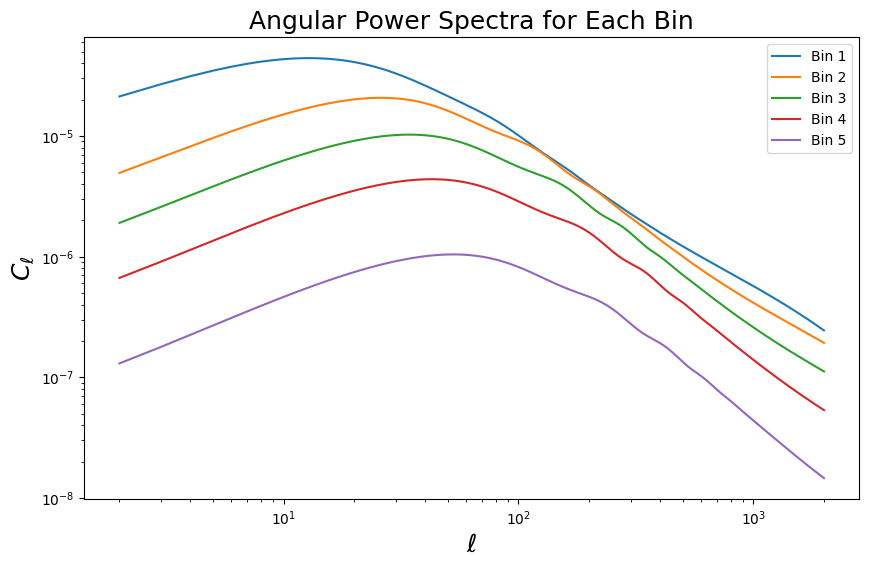

In [16]:
# Compute the redshift distributions for each bin
lens_bins = binning.lens_bins(normalised=True, save_file=False)

# Create NumberCountsTracer objects for each bin
tracers = []
for i in range(n_bins):
    z_bin = z[(z >= bin_edges[i]) & (z < bin_edges[i+1])]
    dNdz_bin = dNdz[(z >= bin_edges[i]) & (z < bin_edges[i+1])]
    bias_bin = b[(z >= bin_edges[i]) & (z < bin_edges[i+1])]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, bias_bin))
    tracers.append(tracer)

# Specify angular multipoles
ell = np.arange(2, 2000)

# Calculate angular power spectra
cls = []
for tracer in tracers:
    cls.append(ccl.angular_cl(cosmo, tracer, tracer, ell))

# Plot the angular power spectra
plt.figure(figsize=(10, 6))
for i, cl in enumerate(cls):
    plt.plot(ell, cl, label=f'Bin {i+1}')
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Angular Power Spectra for Each Bin', fontsize=18)
plt.show()


Calculate the correlation functions for galaxy-galaxy clustering and plot them.

Define the angular scales.

Obtain the correlation predictions.

Plot the correlations.

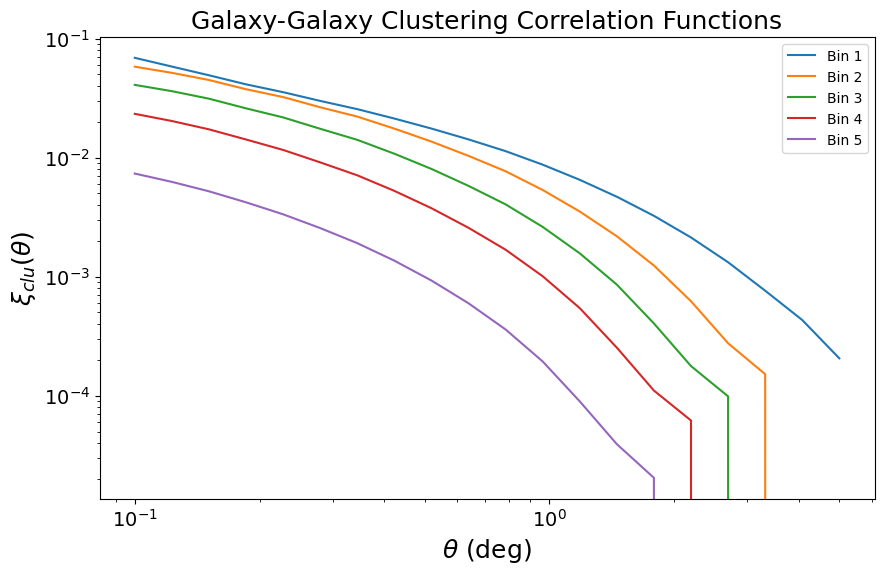

In [17]:
# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Calculate the correlation function for each bin
correlations = []
for cl in cls:
    xi_clu = ccl.correlation(cosmo, ell=ell, C_ell=cl, theta=theta_deg, type='NN', method='FFTLog')
    correlations.append(xi_clu)

# Plot the correlations for galaxy-galaxy clustering
plt.figure(figsize=(10, 6))
for i, xi_clu in enumerate(correlations):
    plt.plot(theta_deg, xi_clu, label=f'Bin {i+1}')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)', fontsize=18)
plt.ylabel(r'$\xi_{clu} (\theta)$', fontsize=18)
plt.title('Galaxy-Galaxy Clustering Correlation Functions', fontsize=18)
plt.show()


Auto-correlation: Gives insight into the clustering properties within individual redshift bins.

Cross-bin correlation: Provides information on how galaxies in different redshift bins correlate with each other, which can be influenced by projection effects and gravitational lensing. (see: Krywonos, J., Muir, J., Johnson, M.C., 2024. Improving Photometric Galaxy Clustering Constraints With Cross-Bin Correlations. arXiv:2404.08039v1 [astro-ph.CO]
See also , LSST DESC Requirements, appendix D1.2


Photo-z uncertainties: Affect both types of correlations by spreading galaxies across bins and impacting the precision of redshift binning.

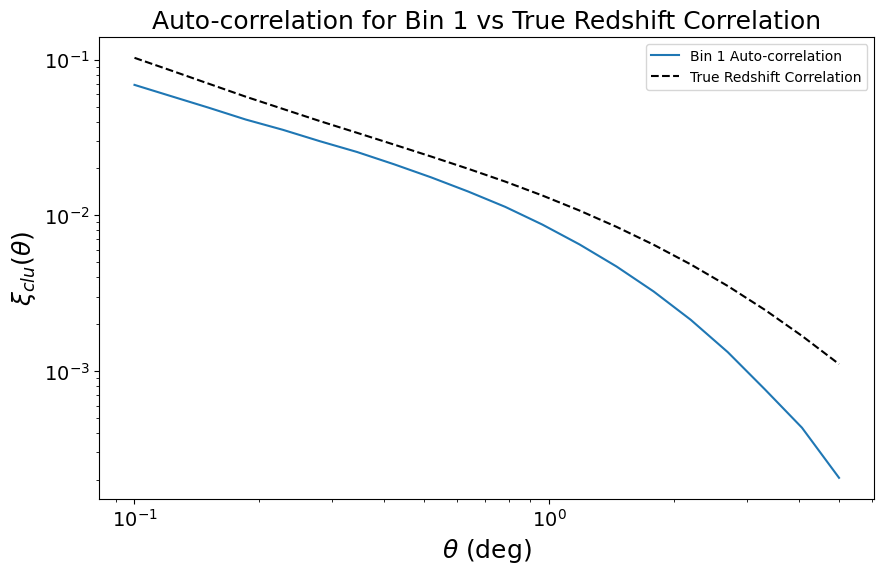

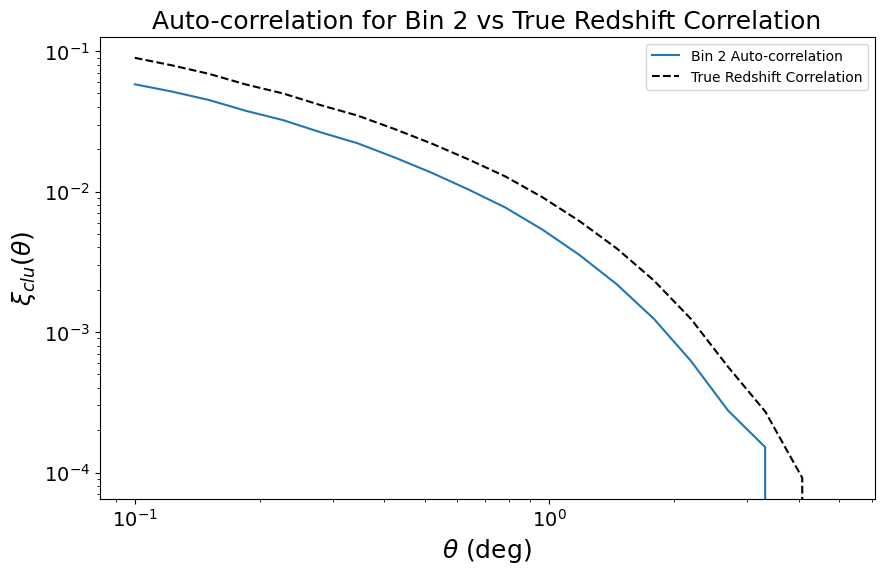

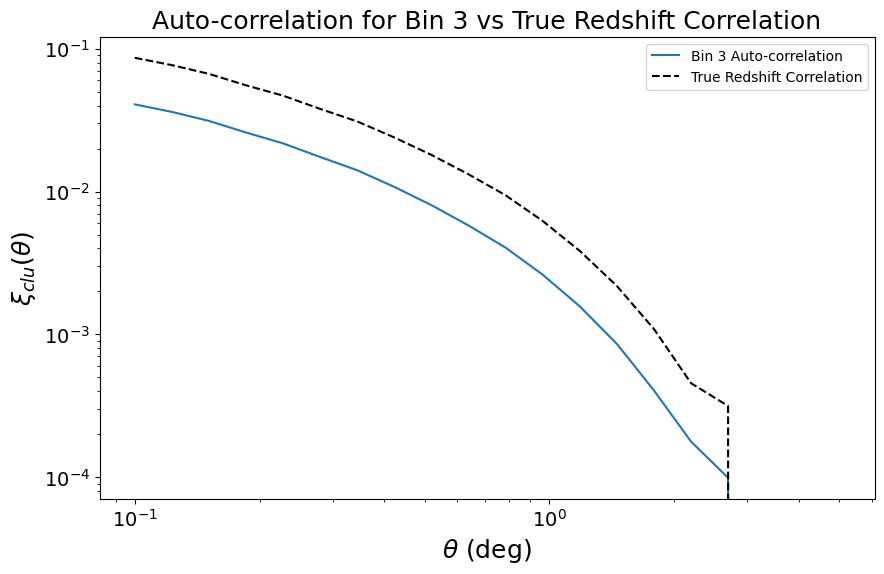

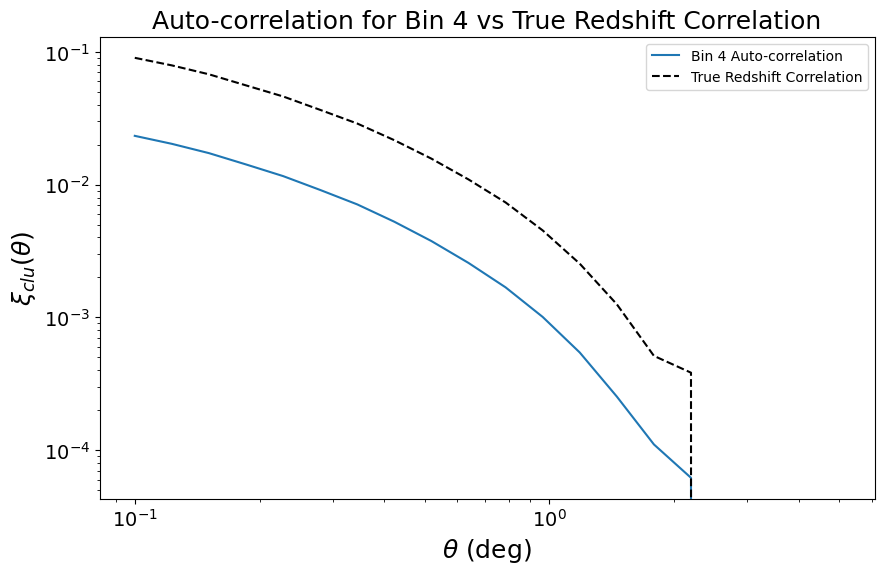

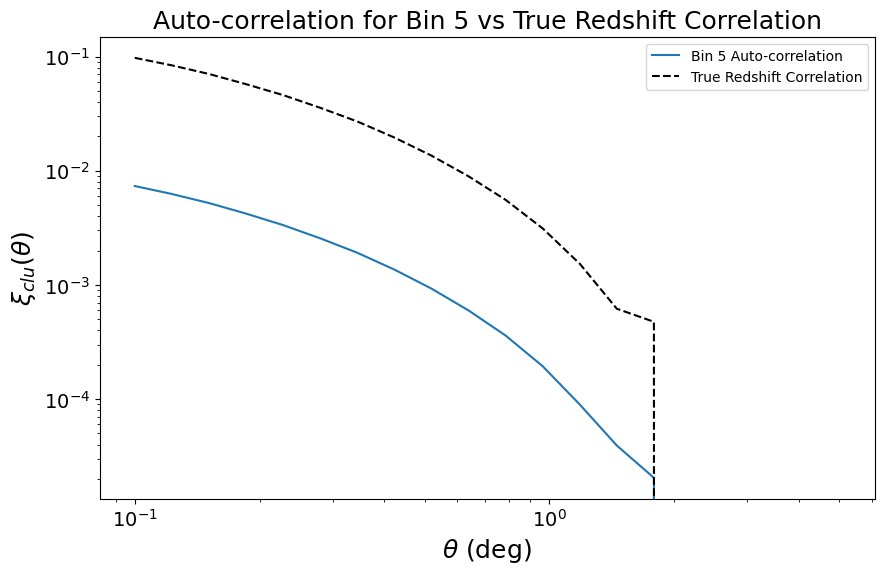

In [21]:
# Define the Smail-type distribution function
def smail_type_distribution(z, alpha, beta):
    z0 = 0.0417 * 26.0 - 0.744
    return (z / z0) ** alpha * np.exp(-(z / z0) ** beta)

# Compute the true redshift distribution (no photo-z uncertainty) for each bin
true_lens_redshift_distribution_dict = {}
for index, (x1, x2) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    mask = (z >= x1) & (z < x2)
    z_bin = z[mask]
    true_lens_redshift_distribution_dict[index] = smail_type_distribution(z_bin, alpha, beta)

# Create the NumberCountsTracer objects for each bin with true redshift distribution
true_tracers = []
for i in range(len(bin_edges) - 1):
    z_bin = z[(z >= bin_edges[i]) & (z < bin_edges[i+1])]
    dNdz_bin = true_lens_redshift_distribution_dict[i]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, 1.5 * np.ones_like(z_bin)))
    true_tracers.append(tracer)

# Calculate the angular power spectra for each bin (auto-correlations) with true redshift distribution
true_cls_matrix = np.zeros((len(bin_edges) - 1, len(ell)))
for i in range(len(bin_edges) - 1):
    true_cls_matrix[i] = ccl.angular_cl(cosmo, true_tracers[i], true_tracers[i], ell)

# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Calculate the correlation function for each bin with true redshift distribution
true_correlations_matrix = np.zeros((len(bin_edges) - 1, len(theta_deg)))
for i in range(len(bin_edges) - 1):
    true_cls = true_cls_matrix[i]
    true_correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=true_cls, theta=theta_deg, type='NN', method='FFTLog')

# Plot the auto-correlation for each bin compared to the true redshift distribution correlation
for i, xi_clu in enumerate(correlations):
    true_corr = true_correlations_matrix[i]
    plt.figure(figsize=(10, 6))
    plt.plot(theta_deg, xi_clu, label=f'Bin {i+1} Auto-correlation')
    plt.plot(theta_deg, true_corr, label='True Redshift Correlation', color='black', linestyle='--')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.xlabel(r'$\theta$ (deg)', fontsize=18)
    plt.ylabel(r'$\xi_{clu} (\theta)$', fontsize=18)
    plt.title(f'Auto-correlation for Bin {i+1} vs True Redshift Correlation', fontsize=18)
    plt.show()


### Bootstrapping and Error Analysis
Quantify the bias and variance in the binned distributions and power spectra using bootstrapping.

1. **Bootstrap Method for Binned Distributions:**
   - Sample with replacement from the redshift data to create bootstrap samples.
   - Compute the binned distributions for each bootstrap sample.
   - Calculate the mean and standard deviation (variance) for the binned distributions across the bootstrap samples.

2. **Bootstrap Method for Angular Power Spectra:**
   - For each bootstrap sample, compute the angular power spectra.
   - Calculate the mean and standard deviation for the power spectra across the bootstrap samples.

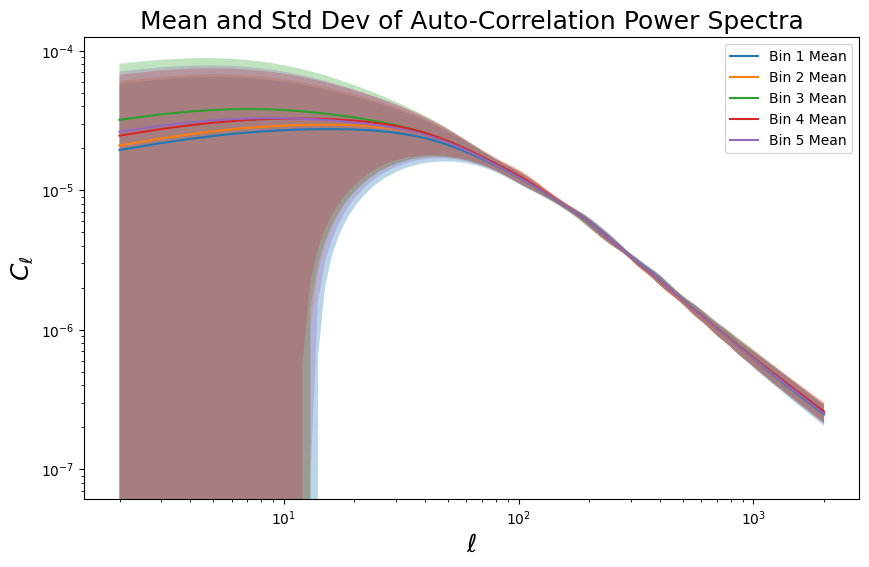

In [25]:
# Bootstrap function to calculate bias and variance
def bootstrap_cls(cosmo, tracers, ell, n_bootstrap=100):
    n_tracers = len(tracers)
    cls_bootstrap_samples = np.zeros((n_bootstrap, n_tracers, len(ell)))

    for n in range(n_bootstrap):
        # Create a bootstrap sample of tracers by sampling with replacement
        bootstrap_sample_indices = np.random.choice(n_tracers, n_tracers, replace=True)
        bootstrap_tracers = [tracers[i] for i in bootstrap_sample_indices]

        # Compute the auto-correlation power spectra for the bootstrap sample
        for i, tracer in enumerate(bootstrap_tracers):
            cls_bootstrap_samples[n, i] = ccl.angular_cl(cosmo, tracer, tracer, ell)

    # Calculate the mean and standard deviation of the auto-correlation power spectra
    mean_cls = np.mean(cls_bootstrap_samples, axis=0)
    std_cls = np.std(cls_bootstrap_samples, axis=0)

    return mean_cls, std_cls

# Bootstrap analysis for auto-correlation power spectra
mean_cls, std_cls = bootstrap_cls(cosmo, true_tracers, ell, n_bootstrap=100)

# Plot the mean and standard deviation of the auto-correlation power spectra
plt.figure(figsize=(10, 6))
for i in range(len(bin_edges) - 1):
    plt.plot(ell, mean_cls[i], label=f'Bin {i+1} Mean')
    plt.fill_between(ell,
                     mean_cls[i] - std_cls[i],
                     mean_cls[i] + std_cls[i],
                     alpha=0.3)

plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Mean and Std Dev of Auto-Correlation Power Spectra', fontsize=18)
plt.show()
